Importing all the neccesary libraries 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers,models
import matplotlib.pyplot as plt
from keras.callbacks import History
import numpy as np
from keras.preprocessing import image

declaring required data variables

In [ ]:
Image_size = 256
Batch_size=32
Channel = 3
epoches = 50

In [6]:
# dataset belongs to tf.data.Dataset which output of function  tf.keras.preprocessing.image_dataset_from_directory
dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (Image_size,Image_size),
    batch_size=Batch_size
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [8]:
#every element is batch of 32
len(dataset)
print(type(dataset))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


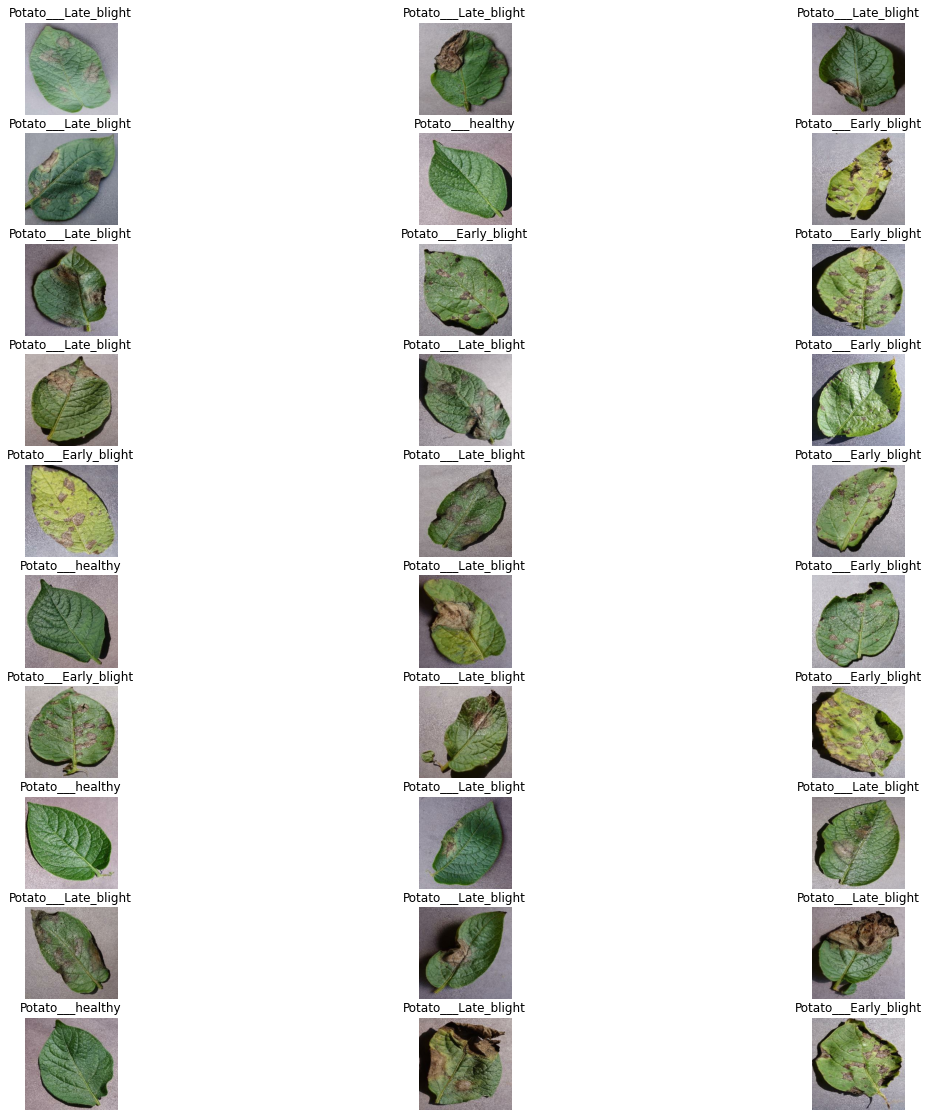

In [22]:
# here we take 1 batch out of 68 batches each contains 32 images
plt.figure(figsize =(20,20))
for image_batch,label_batch in dataset.take(1):
    for i in range(30):
        ax = plt.subplot(10,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
#         print(label_batch.numpy())


In [10]:
#use 80% dataset for training model

train_size = 0.8
test_size = 0.1
len(dataset)*train_size
len(dataset)*test_size

6.800000000000001

In [11]:
# train_data = dataset.take(54)
# test_data = dataset.skip(54)

In [12]:
# validation_data = test_data.skip(6)
# test_data = test_data.take(6)
# print(len(train_data))
# print(len(validation_data))
# print(len(test_data))

# hardcoded representation for generating dataset

In [23]:
# Function for preparing the data [training data , validation data , testing data ] for preparing model

def get_dataset_partitions_tf(ds,train_split = 0.8,val_split=0.1,test_split = 0.1,shuffle=True,shuffle_size = 1000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
        
    train_size = int(ds_size*train_split)
    validation_size = int(ds_size*val_split)
    
    train_data = ds.take(train_size)
    validation_data = ds.skip(train_size).take(validation_size)
    test_data =  ds.skip(train_size).skip(validation_size)
    
    return train_data,validation_data,test_data

In [24]:
train_data ,validation_data,test_data =  get_dataset_partitions_tf(dataset)

In [25]:
print(len(train_data))
print(len(validation_data))
print(len(test_data))

54
6
8


In [13]:
#cache() function keep data into cache memory for quick access
#shuffle(1000) shuffles data every time
#prefetch(buffer_size=tf.data.AUTOTUNE) keeps ready new batch in buffer for fast processing   
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_data = validation_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [33]:
# If images are not in expected shape then Resizing will provide proper sizing and scalling the image rescale it in  0 to 255
resizing_and_rescalling = keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [34]:
#data augmentation for providing variations to model for optimzation and RObustness
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [35]:
#going to build convolutional neural Networks using sequential API one can also use Functional API

Input_shape = (Batch_size , Image_size,Image_size,Channel)
n_classes = 3
model = keras.Sequential([
    resizing_and_rescalling,
    data_augmentation,
    #input layer
    layers.Conv2D(32,(3,3),activation="relu",input_shape = Input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
])
# this function only build the model as per sequentialand weights tobe initialized by default values of tensors 
model.build(input_shape = Input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [36]:
#here which configuration tobe used is defined 
model.compile(
    optimizer = 'adam',
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
#actual training of the model and weight updatation starts from here through backtracking
model.fit(
    train_data,
    epochs = epoches,
    batch_size = Batch_size,
    validation_data  = validation_data
)

Epoch 1/50
54/54 [==============================] - 124s 2s/step - loss: 0.8978 - accuracy: 0.5053 - val_loss: 0.7691 - val_accuracy: 0.6927
Epoch 2/50
54/54 [==============================] - 121s 2s/step - loss: 0.5888 - accuracy: 0.7383 - val_loss: 0.4210 - val_accuracy: 0.8274
Epoch 3/50
54/54 [==============================] - 148s 3s/step - loss: 0.3957 - accuracy: 0.8368 - val_loss: 0.4292 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 134s 2s/step - loss: 0.2929 - accuracy: 0.8850 - val_loss: 0.3520 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 146s 3s/step - loss: 0.2421 - accuracy: 0.9079 - val_loss: 0.2854 - val_accuracy: 0.8958
Epoch 6/50
54/54 [==============================] - 213s 4s/step - loss: 0.2644 - accuracy: 0.8856 - val_loss: 0.1732 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 181s 3s/step - loss: 0.1922 - accuracy: 0.9225 - val_loss: 0.1754 - val_accuracy: 0.9062
Epoch 8/50
54

In [18]:
# scores = model.evaluate(test_data)

8/8 [==============================] - 12s 491ms/step - loss: 1.1225 - accuracy: 0.0938


In [19]:
# scores

[1.1225436925888062, 0.09375]

The class of actual data: Potato___Late_blight
First actual image
1/1 [==============================] - 1s 651ms/step
predicted class is: Potato___healthy


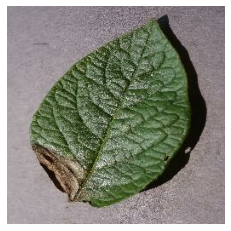

In [20]:
#image_batch contains image data and label_batch data contains the array with class tags i.g 0,1,2
for image_batch,label_batch in test_data.take(1):
    print("The class of actual data:",class_names[label_batch[0]])
    print("First actual image")
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')
    
    #prediction
    predicted = model.predict(image_batch)
    print("predicted class is:",class_names[np.argmax(predicted[0])])

In [38]:
def make_prediction(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)#to make a batch of 32 images
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 56ms/step


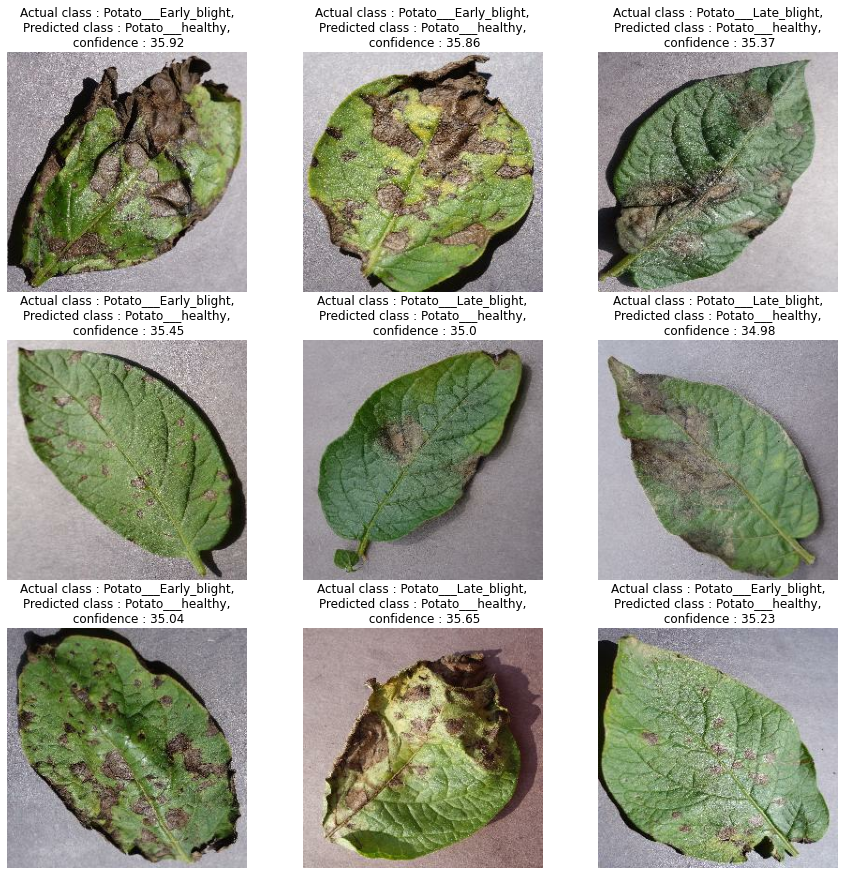

In [43]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in test_data.take(1):
    for k in range(9):
        ax = plt.subplot(3,3,k+1)
        plt.imshow(image_batch[k].numpy().astype('uint8'))
        plt.axis("off")
        predicted_class , confidence = make_prediction(model,image_batch[k].numpy())
        actual_class = class_names[label_batch[k]]
        
        plt.title(f"Actual class : {actual_class},\nPredicted class : {predicted_class},\n confidence : {confidence}")

# Save model

In [32]:
#get an updated model version every time
import os
model_version = max([int(i) for i in os.listdir("../Models")]+[0])+1
model.save(f"../Models/{model_version}")

NameError: name 'model' is not defined